In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.stats as scs
from scipy import stats
import os
import h5py
import datetime
from datetime import date
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import copy
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=10)
sns.set(font=myfont.get_name())
r = lambda x:round(x,2)
import warnings
warnings.filterwarnings("ignore")
from statsmodels.regression.linear_model import OLS
import random

In [2]:
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
zzIcData = pd.read_csv('zz500_from_db.csv')
zzIcData.columns = [int(i) for i in zzIcData.columns]
zzIcData[1] = [int(str(date.fromordinal(int(i)-366)).replace('-','')) for i in zzIcData[1]]
zzIcData.set_index(1,inplace=True)
zz500_pct_ret = (zzIcData[5]/zzIcData[5].shift(1)-1).dropna()
zz500_log_ret = np.log(zzIcData[5]/zzIcData[5].shift(1))

In [3]:
os.chdir(r'C:\Users\bj\Desktop\刘泽丹\Code')
close = pd.read_csv('close.csv',index_col=0)
close.columns = [int(i) for i in close.columns]
open_p = pd.read_csv('open.csv',index_col=0)
open_p.columns = [int(i) for i in open_p.columns]
adjfactor = pd.read_csv('adjfactor.csv',index_col=0)
adjfactor.columns = [int(i) for i in adjfactor.columns]
amt = pd.read_csv('amt.csv',index_col=0)
amt.columns = [int(i) for i in amt.columns]
adjclose = close * adjfactor
adjopen = open_p * adjfactor
log_ret = np.log(adjclose/adjclose.shift(1))
pct_ret = (adjclose/adjclose.shift(1) - 1)
log_ret_oc = np.log(adjclose/adjopen)
pct_ret_oc = (adjclose/adjopen - 1)
STcode = pd.read_csv('STcode_by_date.csv',index_col=0)

In [4]:
def process_ret(df):
    trading_dates = amt[df.name].replace(0,np.nan).dropna().index.tolist()
    return df.loc[trading_dates]
log_ret = log_ret.apply(process_ret).dropna(how='all')
pct_ret = pct_ret.apply(process_ret).dropna(how='all')
log_ret_oc = log_ret_oc.apply(process_ret).dropna(how='all')
pct_ret_oc = pct_ret_oc.apply(process_ret).dropna(how='all')

In [5]:
def process_st(df):
    STstocks = STcode.xs(df.name).dropna().tolist()
    return df[df.index.isin(STstocks)]
ST_pct_ret = pct_ret.apply(process_st,axis=1)
ST_log_ret = log_ret.apply(process_st,axis=1)
ST_pct_ret_oc = pct_ret_oc.apply(process_st,axis=1)
ST_log_ret_oc = log_ret_oc.apply(process_st,axis=1)
def process_nonst(df):
    nonSTstocks = STcode.xs(df.name).dropna().tolist()
    return df[~df.index.isin(nonSTstocks)]
nonST_pct_ret = pct_ret.apply(process_nonst,axis=1)
nonST_log_ret = log_ret.apply(process_nonst,axis=1)
nonST_pct_ret_oc = pct_ret_oc.apply(process_nonst,axis=1)
nonST_log_ret_oc = log_ret_oc.apply(process_nonst,axis=1)

In [6]:
def process_nan(df,base):
    return df.fillna(base.xs(df.name))
zz500based_pct_ret = nonST_pct_ret.apply(process_nan, args=(zz500_pct_ret,), axis=1)
zz500based_log_ret = nonST_log_ret.apply(process_nan, args=(zz500_log_ret,), axis=1)

In [7]:
mid = nonST_pct_ret.rolling(window=9).sum().shift(-9)
mid.iloc[-9:] = 0
mid.iloc[-2] = nonST_pct_ret.iloc[-1]
mid.iloc[-3] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2]
mid.iloc[-4] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3]
mid.iloc[-5] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4]
mid.iloc[-6] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4] + nonST_pct_ret.iloc[-5]
mid.iloc[-7] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4] + nonST_pct_ret.iloc[-5] + nonST_pct_ret.iloc[-6]
mid.iloc[-8] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4] + nonST_pct_ret.iloc[-5] + nonST_pct_ret.iloc[-6] + nonST_pct_ret.iloc[-7]
mid.iloc[-9] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4] + nonST_pct_ret.iloc[-5] + nonST_pct_ret.iloc[-6] + nonST_pct_ret.iloc[-7] + nonST_pct_ret.iloc[-8]
nonST10days_pct_ret = mid + nonST_pct_ret_oc

mid = nonST_pct_ret.rolling(window=5).sum().shift(-5)
mid.iloc[-5:] = 0
mid.iloc[-2] = nonST_pct_ret.iloc[-1]
mid.iloc[-3] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2]
mid.iloc[-4] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3]
mid.iloc[-5] = nonST_pct_ret.iloc[-1] + nonST_pct_ret.iloc[-2] + nonST_pct_ret.iloc[-3] + nonST_pct_ret.iloc[-4]
nonST6days_pct_ret = mid + nonST_pct_ret_oc

mid = nonST_pct_ret.rolling(window=2).sum().shift(-2)
mid.iloc[-2:] = 0
mid.iloc[-2] = nonST_pct_ret.iloc[-1]
nonST3days_pct_ret = mid + nonST_pct_ret_oc

mid = nonST_pct_ret.rolling(window=1).sum().shift(-1)
mid.iloc[-1:] = 0
nonST2days_pct_ret = mid + nonST_pct_ret_oc


mid = nonST_log_ret.rolling(window=9).sum().shift(-9)
mid.iloc[-9:] = 0
mid.iloc[-2] = nonST_log_ret.iloc[-1]
mid.iloc[-3] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2]
mid.iloc[-4] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3]
mid.iloc[-5] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4]
mid.iloc[-6] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4] + nonST_log_ret.iloc[-5]
mid.iloc[-7] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4] + nonST_log_ret.iloc[-5] + nonST_log_ret.iloc[-6]
mid.iloc[-8] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4] + nonST_log_ret.iloc[-5] + nonST_log_ret.iloc[-6] + nonST_log_ret.iloc[-7]
mid.iloc[-9] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4] + nonST_log_ret.iloc[-5] + nonST_log_ret.iloc[-6] + nonST_log_ret.iloc[-7] + nonST_log_ret.iloc[-8]
nonST10days_log_ret = mid + nonST_log_ret_oc

mid = nonST_log_ret.rolling(window=5).sum().shift(-5)
mid.iloc[-5:] = 0
mid.iloc[-2] = nonST_log_ret.iloc[-1]
mid.iloc[-3] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2]
mid.iloc[-4] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3]
mid.iloc[-5] = nonST_log_ret.iloc[-1] + nonST_log_ret.iloc[-2] + nonST_log_ret.iloc[-3] + nonST_log_ret.iloc[-4]
nonST6days_log_ret = mid + nonST_log_ret_oc

mid = nonST_log_ret.rolling(window=2).sum().shift(-2)
mid.iloc[-2:] = 0
mid.iloc[-2] = nonST_log_ret.iloc[-1]
nonST3days_log_ret = mid + nonST_log_ret_oc

mid = nonST_log_ret.rolling(window=1).sum().shift(-1)
mid.iloc[-1:] = 0
nonST2days_log_ret = mid + nonST_log_ret_oc

5.29761365172 0 1.67167385697e-08
5.34077665412 0 1.84494857759e-08


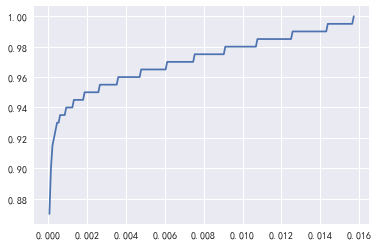

In [39]:
np.random.seed(1234)
stock = 18
num_bins= 200
data = nonST10days_pct_ret[stock].iloc[-600:-100]
ld = 0.97
weights = [(ld**(i-1))*(1-ld)/(1-ld**len(data)) for i in range(len(data))][::-1]
data = data * weights
original_length = len(data)
data = -data[data<0]
loss_length = len(data)
#data = data[data<0.099]
#nonlimitloss_length = len(data)
#limitloss_length = loss_length - nonlimitloss_length
data = data.tolist()
counts, bin_edges = np.histogram(data, bins=num_bins)
cdf = np.cumsum(counts)
#plt.plot(bin_edges[1:], cdf/cdf[-1])
c,l,s = stats.genpareto.fit(data, floc = 0)
print(c,l,s)
np.random.seed(1234)
data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
c,l,s = stats.genpareto.fit(data, floc = 0)
print(c,l,s)
num_bins = 200
counts, bin_edges = np.histogram(data, bins=num_bins)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram(stats.genpareto.rvs(c, loc = l,scale = s, size=len(data)*100), bins=num_bins)
cdf = np.cumsum(counts)
#plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.show()

In [12]:
data = nonST10days_pct_ret[1].iloc[-600:-100]
original_length = len(data)
data = -data[data<0]
loss_length = len(data)
np.random.seed(994513)
data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
c,l,s = stats.genpareto.fit(data, floc = 0)
var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
print(var)

0.13054902528


In [107]:
data = nonST10days_pct_ret[155].iloc[-600:-100].dropna()
data.name = 'ret'
ld = 0.97
weights = pd.Series([(ld**(i-1))*(1-ld)/(1-ld**len(data)) for i in range(len(data))][::-1],index=data.index)
weights.name = 'weight' 
data = pd.concat([data,weights],axis=1).sort_values('ret')
data['cum weight'] = data['weight'].cumsum()/data['weight'].sum()
if data.iloc[0,2] >= 0.01:
    var = data.iloc[0,0]
else:
    sub_plus = data[data['cum weight']>0.01].iloc[0,:]
    sub_minus = data[data['cum weight']<0.01].iloc[-1,:]
    var = (0.01 - sub_minus['cum weight'])/(sub_plus['cum weight'] - sub_minus['cum weight']) * \
        (sub_plus['ret'] - sub_minus['ret']) + sub_minus['ret']

In [108]:
print(var)

-0.251369481512


In [235]:
((data.mean()**2)/(data.std()**2)+1)*1/2*data.mean()

0.039408651149023609

In [224]:
(s/c) * ((0.01)**(-c) - 1)

0.14967183931250291

In [225]:
bin_edges[1:][list(cdf/cdf[-1]).index(next(i for i in cdf/cdf[-1] if i>(1-0.01)))]

0.15374673083328394

In [226]:
data.sort_values(ascending=False).iloc[len(data)//int(1/0.01)]

0.14952579291505569

(s/c) * (((0.05 - limitloss_length/original_length)/(nonlimitloss_length/original_length))**(-c) - 1)

nonST_log_ret[stock].dropna().sort_values().iloc[len(nonST_log_ret[stock].dropna())//20]

In [227]:
(s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)

0.12742832271843163

In [228]:
bin_edges[1:][list(cdf/cdf[-1]).index(next(i for i in cdf/cdf[-1] if i>(1-(0.01)/(loss_length/original_length))))]

0.13031976328151731

In [229]:
(((s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)) + s)/(1 - c)

0.15416118780859572

In [230]:
-nonST6days_log_ret[stock].dropna().sort_values().iloc[:len(nonST6days_log_ret[stock].dropna())//int(1/0.01)].mean()

0.16732861121455758

In [737]:
min_marginal_var = 0.001

In [741]:
np.random.seed(2313)
sub = nonST10days_pct_ret.loc[:,[300337,2505,300633,603016,603686,766,300238,2501,600069,600110,601880,2308,300090,600270,18,935,2725,300074,\
                                603776,601877,2683,600978,300705,600715,603486,600048,584,601872,603157,603357,2676,544,1979,300085,600372,\
                                566,300033,2596,600606,2220,2239,2491,2146,603111,603330,2076,603685,993,300083,600187]].iloc[-500:,:].copy()
weight = [1/len(list(sub))] * len(list(sub))
portfolio = (sub * weight).sum(axis = 1)
data = portfolio.copy()
print(-data.sort_values().iloc[len(data)//int(1/0.01)])
original_length = len(data)
data = -data[data<0]
loss_length = len(data)
data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
c,l,s = stats.genpareto.fit(data, floc = 0)
var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
print(var)

0.145190429373
0.129489871089


In [742]:
adjust = []
np.random.seed(2313)
for st in list(sub):
    removed_sub = sub.copy()
    removed_sub[st] = 0
    removed_portfolio = (removed_sub * weight).sum(axis = 1)
    data = removed_portfolio.copy()
    original_length = len(data)
    data = -data[data<0]
    loss_length = len(data)
    data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
    c,l,s = stats.genpareto.fit(data, floc = 0)
    removed_var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
    print(st, var-removed_var)
    adjust.append(max(min_marginal_var,var-removed_var))
ori = adjust
adjust = [1/i for i in adjust]
adjust = [i**(2)/np.sum(np.array(adjust)**(2)) for i in adjust]

300337 0.00240107319149
2505 0.0018730104954
300633 0.00165440118834
603016 0.000715917310469
603686 0.00195185568721
766 0.000171775661452
300238 0.0028642075736
2501 0.00364441835156
600069 0.0018280003903
600110 0.00259194092463
601880 0.000901228157535
2308 0.00263586337475
300090 0.00184767884118
600270 0.000137233748655
18 0.00397001891848
935 0.00144600519222
2725 -0.000575380770496
300074 0.0049292669943
603776 0.00270846964406
601877 0.00156815529252
2683 0.00146009807855
600978 0.00347328087377
300705 0.00287692429695
600715 0.00177419980416
603486 0.00190947439725
600048 0.00131224016574
584 0.00256192013199
601872 0.000225974884851
603157 0.00324187607912
603357 0.00145226130551
2676 0.00335577864019
544 0.00516433517657
1979 0.00152196141879
300085 0.00291539183616
600372 0.00147314155673
566 0.00155870325166
300033 0.00194686257176
2596 0.00234677727251
600606 0.00191662828122
2220 0.00325545939817
2239 0.00215371844275
2491 0.00294016787708
2146 0.00288918783087
603111 0

In [743]:
np.random.seed(2313)
weight = pd.Series(adjust)
while(True):
    if weight.max() / weight.min() <= 5:
        break
    else:
        weight = weight - (weight - weight.mean())* 1/200
weight = weight.tolist()


portfolio = (sub * weight).sum(axis = 1)
data = portfolio.copy()
print(-data.sort_values().iloc[len(data)//int(1/0.01)])
original_length = len(data)
data = -data[data<0]
loss_length = len(data)

data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()

c,l,s = stats.genpareto.fit(data, floc = 0)
var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
print(var)

0.113521179037
0.108201494445


In [744]:
weight

[0.014254628537339265,
 0.018470895321392636,
 0.02150516027142738,
 0.045483536383388874,
 0.017618371700008392,
 0.045483536383388874,
 0.012306580890806221,
 0.010545713616332214,
 0.019007788877681082,
 0.013324966479621617,
 0.045483536383388874,
 0.013139100166965949,
 0.01876822917543607,
 0.045483536383388874,
 0.010098235134975196,
 0.025770733612259455,
 0.045483536383388874,
 0.009256012223863538,
 0.012851449960135874,
 0.023065323237223188,
 0.025423598918240423,
 0.010832949895323019,
 0.012265955486828897,
 0.019703915146846145,
 0.01806349343820702,
 0.029642417667127566,
 0.013457542287581446,
 0.045483536383388874,
 0.011296019935621184,
 0.025615386037845158,
 0.011056117623072704,
 0.00911767556009545,
 0.02401213715862495,
 0.012146285093246561,
 0.025111150210858427,
 0.023252227668728614,
 0.017669306927719588,
 0.014561389765469846,
 0.01798628125343612,
 0.011266082499847781,
 0.015846437359928866,
 0.012071682659999071,
 0.012227284870831781,
 0.01187674921537

adjust = []
for st in list(sub):
    removed_sub = sub.copy()
    removed_sub[st] = 0
    removed_portfolio = (removed_sub * weight).sum(axis = 1)
    data = removed_portfolio.copy()
    original_length = len(data)
    data = -data[data<0]
    loss_length = len(data)
    
    data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
    
    c,l,s = stats.genpareto.fit(data, floc = 0)
    removed_var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
    print(st, var - removed_var)
    adjust.append(var-removed_var)

adjust = []
for st in list(sub):
    removed_sub = sub.copy()
    removed_sub[st] = 0
    removed_portfolio = (removed_sub * weight).sum(axis = 1)
    data = removed_portfolio.copy()
    original_length = len(data)
    data = -data[data<0]
    loss_length = len(data)
    data = data[data<0.099]
    nonlimitloss_length = len(data)
    limitloss_length = loss_length - nonlimitloss_length
    
    data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
    
    c,l,s = stats.genpareto.fit(data, floc = 0)
    removed_var = (s/c) * (((0.05 - limitloss_length/original_length)/(nonlimitloss_length/original_length))**(-c) - 1)
    print(st, var - removed_var)
    adjust.append(var-removed_var)

In [698]:
min_marginal_var = 0.0002

In [699]:
np.random.seed(2313)
sub = nonST2days_pct_ret.loc[:,[300337,2505,300633,603016,603686,766,300238,2501,600069,600110,601880,2308,300090,600270,18,935,2725,300074,\
                                603776,601877,2683,600978,300705,600715,603486,600048,584,601872,603157,603357,2676,544,1979,300085,600372,\
                                566,300033,2596,600606,2220,2239,2491,2146,603111,603330,2076,603685,993,300083,600187]].iloc[-500:,:].copy()
weight = [1/len(list(sub))] * len(list(sub))
portfolio = (sub * weight).sum(axis = 1)
data = portfolio.copy()
print(-data.sort_values().iloc[len(data)//int(1/0.01)])
original_length = len(data)
data = -data[data<0]
loss_length = len(data)
data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
c,l,s = stats.genpareto.fit(data, floc = 0)
var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
print(var)

0.0434424797872
0.0486656622087


In [700]:
adjust = []
np.random.seed(2313)
for i_st,st in enumerate(list(sub)):
    data = sub[st]*weight[i_st]
    original_length = len(data)
    data = -data[data<0]
    loss_length = len(data)
    data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()
    c,l,s = stats.genpareto.fit(data, floc = 0)
    removed_var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
    print(st, removed_var)
    adjust.append(removed_var)
ori = adjust

300337 0.00218354139848
2505 0.00147648830266
300633 0.00216039775373
603016 0.00255136824243
603686 0.00149308741673
766 0.00206083779323
300238 0.00213678539811
2501 0.00172438049407
600069 0.00220266159096
600110 0.00173175766072
601880 0.00115472757366
2308 0.00166071203863
300090 0.00212062768871
600270 0.00106059044326
18 0.00221921538571
935 0.0020689490061
2725 0.00224695303968
300074 0.00196893643252
603776 0.00248005650249
601877 0.00157605953093
2683 0.00199150395438
600978 0.00149021610439
300705 0.00258727843818
600715 0.00202470709763
603486 0.00204043431977
600048 0.00174531927254
584 0.00166703747598
601872 0.0011547460499
603157 0.0021185425174
603357 0.00179304659932
2676 0.00222051230369
544 0.00188599934434
1979 0.00173848769835
300085 0.00228263021543
600372 0.00160925846528
566 0.00169208867832
300033 0.00161668280445
2596 0.00245175200297
600606 0.00120930070871
2220 0.00206284227773
2239 0.00153897334022
2491 0.00163387788293
2146 0.00186422960523
603111 0.00203

In [701]:
adjust = [1/i for i in adjust]

In [702]:
adjust = [(i**5)/np.sum(np.array(adjust)**5) for i in adjust]

In [703]:
adjust

[0.0046608320125217598,
 0.032970121551085321,
 0.0049158884143405525,
 0.0021399561502612034,
 0.031177725183904891,
 0.0062237415645502916,
 0.0051935709070403619,
 0.015174175192215356,
 0.0044620220017827037,
 0.014853712513833802,
 0.11268676708227909,
 0.018314663007801209,
 0.0053944660401858222,
 0.17239793289636976,
 0.0042980684545785531,
 0.0061026950424236228,
 0.0040392489595863067,
 0.007818296312420538,
 0.0024658276875678359,
 0.023790716038182041,
 0.007385242088874905,
 0.03147924731168189,
 0.0019955138918958432,
 0.0067992275366379612,
 0.0065412011306036372,
 0.014285524149412216,
 0.017969822440739837,
 0.11267775228377053,
 0.0054210658132692853,
 0.012482820307399972,
 0.0042855314047663641,
 0.0096953371145600264,
 0.014568421288702232,
 0.003733299160867079,
 0.021435893456595394,
 0.016678423733753316,
 0.020948190097239385,
 0.002611487237111096,
 0.089453855709090715,
 0.0061935619131648408,
 0.026798785875996281,
 0.019868845455354958,
 0.01027480524241864

In [704]:
np.random.seed(2313)

weight = pd.Series(adjust)
while(True):
    if weight.max() / weight.min() <= 5:
        break
    else:
        weight = weight - (weight - weight.mean())* 1/200
weight = weight.tolist()


portfolio = (sub * weight).sum(axis = 1)
data = portfolio.copy()
print(-data.sort_values().iloc[len(data)//int(1/0.01)])
original_length = len(data)
data = -data[data<0]
loss_length = len(data)

data = pd.DataFrame(np.sort(np.random.choice(data,(1000,200)))).mean()

c,l,s = stats.genpareto.fit(data, floc = 0)
var = (s/c) * (((0.01)/(loss_length/original_length))**(-c) - 1)
print(var)

0.0403265279832
0.045144196057


In [705]:
np.max(weight)/np.min(weight)

4.9765440587446932

In [706]:
np.max(weight),np.min(weight)

(0.070084460717568353, 0.014082957950390735)

In [708]:
list(sub)[weight.index(0.070084460717568353)]

600270

In [ ]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                print(distribution.name,sse)

        except Exception:
            pass
    print(best_sse)
    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_xlabel('Return')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_xlabel('Return')
ax.set_ylabel('Frequency')

In [ ]:
dist_str

In [4]:
pct_ret

,1,2,4,5,6,7,8,9,10,11,...,603987,603988,603989,603990,603991,603993,603996,603997,603998,603999
20090105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090106,0.060762,0.029851,0.029810,0.031250,0.040541,0.032448,0.030973,0.038741,0.020913,0.033248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090107,-0.030097,-0.005797,0.050000,-0.011364,-0.007421,-0.031429,0.012876,-0.006993,0.020484,0.007426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090108,-0.039039,0.005831,0.050125,-0.026820,-0.018692,0.035398,0.025424,-0.032864,0.012774,0.002457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090109,0.026042,-0.001449,0.038186,0.043307,0.009524,0.000000,0.018595,0.036408,0.007207,0.024510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090112,0.001015,-0.011611,-0.020690,-0.007547,0.001887,-0.025641,0.050710,0.035129,-0.007156,0.004785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090113,-0.039554,-0.035242,-0.049296,-0.026616,-0.032015,-0.043860,-0.050193,0.011312,-0.025225,-0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090114,0.077086,0.048706,0.012346,0.031250,0.038911,0.024465,0.032520,0.053691,0.018484,0.032581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090115,0.009804,-0.005806,-0.004878,0.011364,0.005618,0.014925,-0.005906,0.059448,0.009074,0.004854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090116,0.031068,0.010219,0.004902,0.014981,0.024209,0.011765,0.001980,0.062124,0.035971,0.007246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = pd.DataFrame([(600270,20181105,20181204,5),
    (2285,20181115,20181128,6),
    (600811,20181115,20181214,10),
    (600993,20181116,20181129,5),
    (601166,20181116,20181129,17),
    (400,20181116,20181217,10),
    (6,20181116,20181129,5),
    (601985,20181116,20181129,5),
    (735,20181119,20181204,10),
    (600491,20181120,20181203,5),
    (600491,20181120,20181219,8),
    (300222,20181121,20181220,5),
    (877,20181121,20181204,10),
    (2611,20181121,20181204,5),
    (735,20181121,20181220,5),
    (2002,20181121,20181220,6),
    (2611,20181122,20181221,5),
    (600703,20181123,20181206,5),
    (2266,20181123,20181224,5),
    (2032,20181123,20181206,5),
    (600323,20181126,20181210,5),
    (601009,20181126,20181210,6),
    (600377,20181127,20181210,5),
    (600240,20181127,20181210,5)])

In [12]:
df.set_index(0)

,1,2,3
0,,,
600270,20181105,20181204,5
2285,20181115,20181128,6
600811,20181115,20181214,10
600993,20181116,20181129,5
601166,20181116,20181129,17
400,20181116,20181217,10
6,20181116,20181129,5
601985,20181116,20181129,5
735,20181119,20181204,10


In [10]:
record = pd.DataFrame()
for i in range(len(df)):
    stock = df.iloc[i,0]
    start = df.iloc[i,1]
    end =  df.iloc[i,2]
    returns = pct_ret[stock]
    returns = returns[(returns.index>=start) & (returns.index<=end)]
    record = pd.concat([record,returns],axis=1)

In [11]:
record

,600270,2285,600811,600993,601166,400,6,601985,735,600491,...,735,2002,2611,600703,2266,2032,600323,601009,600377,600240
20181105,0.016183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181106,-0.001874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181107,-0.005162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181108,-0.020283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181109,-0.003370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181112,0.008696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181113,0.010536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181114,-0.005687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181115,0.024309,0.007737,0.004890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181116,0.004653,0.013436,0.019465,0.021038,-0.004405,-0.005198,0.003636,-0.001786,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
full_df_sub = pd.DataFrame()
for i in range(len(record)):
    sub = record.iloc[i]
    sub_notnull_index = [index for index,value in enumerate(sub.tolist()) if pd.notnull(value)]
    df_sub = df.iloc[sub_notnull_index][3]
    df_sub = df_sub/df_sub.sum()
    full_df_sub = pd.concat([full_df_sub,df_sub],axis=1)

In [32]:
full_df_sub = full_df_sub.T
full_df_sub.index = record.index
full_df_sub.columns = record.columns

In [35]:
(record*full_df_sub).sum(axis=1)

20181105    0.016183
20181106   -0.001874
20181107   -0.005162
20181108   -0.020283
20181109   -0.003370
20181112    0.008696
20181113    0.010536
20181114   -0.005687
20181115    0.010327
20181116    0.004541
20181119    0.009410
20181120   -0.032080
20181121    0.005060
20181122    0.000380
20181123   -0.039620
20181126   -0.001168
20181127    0.001218
dtype: float64

In [38]:
zz500_pct_ret.loc[(record*full_df_sub).sum(axis=1).index]

20181105    0.000649
20181106   -0.000615
20181107   -0.005174
20181108   -0.007431
20181109   -0.003129
20181112    0.025883
20181113    0.018263
20181114   -0.003950
20181115    0.016347
20181116    0.008503
20181119    0.002498
20181120   -0.028537
20181121    0.003796
20181122   -0.000735
20181123   -0.038794
20181126   -0.001669
20181127    0.004623
Name: 5, dtype: float64

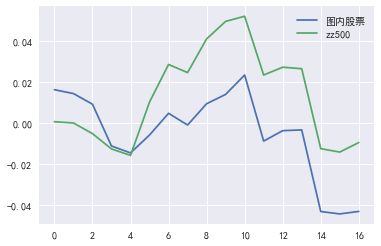

In [43]:
plt.plot((record*full_df_sub).sum(axis=1).cumsum().tolist(),label = '图内股票')
plt.plot(zz500_pct_ret.loc[(record*full_df_sub).sum(axis=1).index].cumsum().tolist(),label = 'zz500')
plt.legend()